<a href="https://colab.research.google.com/github/esfandiaryfard/machine-learning/blob/main/video_gan_TGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The input .npy file is here: https://github.com/tychovdo/MovingMNIST/raw/master/mnist_test_seq.npy.gz

I trained and saved the results here: https://drive.google.com/drive/folders/1THkGfpF9npkiKUP_Rv22hl-Ei21Do2pd?usp=share_link

In [2]:
# code sourced from https://github.com/tychovdo/MovingMNIST

from __future__ import print_function
import torch.utils.data as data
from PIL import Image
import os
import os.path
import errno
import numpy as np
import torch
import codecs


class MovingMNIST(data.Dataset):
    """`MovingMNIST <http://www.cs.toronto.edu/~nitish/unsupervised_video/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``processed/training.pt``
            and  ``processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        split (int, optional): Train/test split size. Number defines how many samples
            belong to test set. 
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in an PIL
            image and returns a transformed version. E.g, ``transforms.RandomCrop``
    """
    urls = [
        'https://github.com/tychovdo/MovingMNIST/raw/master/mnist_test_seq.npy.gz'
    ]
    raw_folder = 'raw'
    processed_folder = 'processed'
    training_file = 'moving_mnist_train.pt'
    test_file = 'moving_mnist_test.pt'

    def __init__(self, root, train=True, split=1000, transform=None, target_transform=None, download=True):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.split = split
        self.train = train  # training set or test set


        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        if self.train:
            self.train_data = torch.load(
                os.path.join(self.root, self.processed_folder, self.training_file))
        else:
            self.test_data = torch.load(
                os.path.join(self.root, self.processed_folder, self.test_file))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (seq, target) where sampled sequences are splitted into a seq
                    and target part
        """
        if self.train:
            seq, target = self.train_data[index, :10], self.train_data[index, 10:]
        else:
            seq, target = self.test_data[index, :10], self.test_data[index, 10:]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        # seq = Image.fromarray(seq.numpy(), mode='L')
        # target = Image.fromarray(target.numpy(), mode='L')

        # if self.transform is not None:
        #     seq = self.transform(seq)

        # if self.target_transform is not None:
        #     target = self.target_transform(target)

        return seq, target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root, self.processed_folder, self.training_file)) and \
            os.path.exists(os.path.join(self.root, self.processed_folder, self.test_file))

    def download(self):
        """Download the Moving MNIST data if it doesn't exist in processed_folder already."""
        from six.moves import urllib
        import gzip

        if self._check_exists():
            return

        # download files
        try:
            os.makedirs(os.path.join(self.root, self.raw_folder))
            os.makedirs(os.path.join(self.root, self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        for url in self.urls:
            print('Downloading ' + url)
            data = urllib.request.urlopen(url)
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.root, self.raw_folder, filename)
            with open(file_path, 'wb') as f:
                f.write(data.read())
            with open(file_path.replace('.gz', ''), 'wb') as out_f, \
                    gzip.GzipFile(file_path) as zip_f:
                out_f.write(zip_f.read())
            os.unlink(file_path)

        # process and save as torch files
        print('Processing...')

        training_set = torch.from_numpy(
            np.load(os.path.join(self.root, self.raw_folder, 'mnist_test_seq.npy')).swapaxes(0, 1)[:-self.split]
        )
        test_set = torch.from_numpy(
            np.load(os.path.join(self.root, self.raw_folder, 'mnist_test_seq.npy')).swapaxes(0, 1)[-self.split:]
        )

        with open(os.path.join(self.root, self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.root, self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Train/test: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [3]:
import torch
import torch.nn as nn
import numpy as np
import math


class CLSTM_cell(nn.Module):
    def __init__(self, n_filters):
        """Convolutional LSTM Cell

        Args:
            n_filters (int): Number of LSTM channels
        """
        super(CLSTM_cell, self).__init__()
        self.w_x = nn.Conv2d(n_filters, n_filters * 4, kernel_size=3,
                             padding=1)
        self.w_h = nn.Conv2d(n_filters, n_filters * 4, kernel_size=3,
                             padding=1, bias=False)

    def forward(self, x, h=None, c=None):
        xifoc = self.w_x(x)
        xi, xf, xo, xc = xifoc.chunk(4, dim=1)
        if h is not None:
            hi, hf, ho, hc = self.w_h(h).chunk(4, dim=1)
        else:
            hi, hf, ho, hc = torch.zeros_like(xifoc).chunk(4, dim=1)

        if c is None:
            c = torch.zeros_like(x)

        ci = torch.sigmoid(xi + hi)
        cf = torch.sigmoid(xf + hf)
        co = torch.sigmoid(xo + ho)
        cc = cf * c + ci * torch.tanh(xc + hc)
        ch = torch.tanh(cc) * co

        return ch, cc


class CLSTM(nn.Module):
    def __init__(self, n_filters, n_frames):
        """Full Convolutional LSTM

        Args:
            n_filters (int): Number of LSTM channels
            n_frames (int): Frames to generate
        """
        super(CLSTM, self).__init__()
        self.cell = CLSTM_cell(n_filters)
        self.n_frames = n_frames

    def forward(self, z):
        # Assume z is in proper convolutional shape
        out = torch.stack([torch.zeros_like(z)]*self.n_frames, dim=1)

        h, c = None, None
        for i in range(self.n_frames):
            h, c = self.cell(z, h, c)
            out[:, i] = h
            z = torch.zeros_like(z)

        return out


class Up(nn.Module):
    def __init__(self, cin, cout):
        """Upscale and convolutions in ResNet setup

        Args:
            cin (int): in channels
            cout (int): out channels
        """
        super(Up, self).__init__()
        self.relu = nn.ReLU()

        # define main branch
        self.upsample = nn.Upsample(scale_factor=2)
        self.bn1 = nn.BatchNorm2d(cin)
        self.convm1 = nn.Conv2d(cin, cout, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(cout)
        self.convm2 = nn.Conv2d(cout, cout, kernel_size=3, padding=1)

        # define skip branch
        self.sconv = nn.Conv2d(cin, cout, kernel_size=1)

        # initialize
        nn.init.xavier_uniform_(self.convm1.weight, gain=math.sqrt(2))
        nn.init.xavier_uniform_(self.convm2.weight, gain=math.sqrt(2))
        nn.init.xavier_uniform_(self.sconv.weight)

    def forward(self, x):
        # compute main
        h = self.bn1(x)
        h = self.relu(h)
        h = self.upsample(h)
        h = self.convm1(h)
        h = self.bn2(h)
        h = self.relu(h)
        h = self.convm2(h)

        # compute skip
        s = self.upsample(x)
        s = self.sconv(s)

        return h + s


class Render(nn.Module):
    def __init__(self, cin, colors=3):
        """Render an image given the parameters

        Args:
            cin (int): in channels
            colors (int, optional): Color channels. Defaults to 3.
        """
        super(Render, self).__init__()
        self.bn = nn.BatchNorm2d(cin)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(cin, colors, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv(x)
        x = torch.tanh(x)

        return x


class Generator_CLSTM(nn.Module):
    def __init__(self, z_dim=256,
                 tempc=1024,
                 zt_dim=3,
                 upchannels=[512, 256, 128],
                 subchannels=[64, 32, 32],
                 n_frames=16,
                 colors=3):
        """Full generator CLSTM model

        Args:
            z_dim (int, optional): Latent z. Defaults to 256.
            tempc (int, optional): CLSTM channels. Defaults to 1024.
            zt_dim (int, optional): CLSTM window size. Defaults to 3.
            upchannels (list, optional): Defaults to [512, 256, 128].
            subchannels (list, optional): Defaults to [64, 32, 32].
            n_frames (int, optional): Frames to generate. Defaults to 16.
            colors (int, optional): Number of colors. Defaults to 3.
        """
        super(Generator_CLSTM, self).__init__()
        assert len(subchannels) == 3
        self.tempc = tempc
        self.zt_dim = zt_dim
        self.colors = colors

        self.fc = nn.Linear(z_dim, zt_dim**2 * tempc)
        self.temp = CLSTM(tempc, n_frames)

        self.build = nn.Sequential()
        for i in range(len(upchannels)):
            if not i:
                self.build.add_module('Up1', Up(tempc, upchannels[0]))
            else:
                self.build.add_module(f'Up{i+1}', Up(upchannels[i-1],
                                      upchannels[i]))

        self.buildr = Render(upchannels[-1], colors=colors)

        self.sup1 = Up(upchannels[-1], subchannels[0])
        self.sup1r = Render(subchannels[0], colors=colors)
        self.sup2 = Up(subchannels[0], subchannels[1])
        self.sup2r = Render(subchannels[1], colors=colors)
        self.sup3 = Up(subchannels[1], subchannels[2])
        self.sup3r = Render(subchannels[2], colors=colors)

    def subsample(self, h, N, T, frames=4):
        # to vid
        _, C, H, W = h.shape
        h = h.view(N, T, C, H, W)
        h = h[:, np.random.randint(min(frames, T))::frames]
        N, T, C, H, W = h.shape
        # to train
        h = h.contiguous().view(N * T, C, H, W)
        return h, T

    def forward(self, z, test=False):
        """Compute generator forward pass

        Args:
            z (torch.Tensor): Latent z [batch_size, z_dim]
            test (bool, optional): Produce test videos. Defaults to False.

        Returns:
            list(torch.Tensor) or torch.Tensor: Subsampled or regular videos
        """
        h = self.fc(z)
        h = h.view(-1, self.tempc, self.zt_dim, self.zt_dim)
        h = self.temp(h)
        N, T, C, H, W = h.shape
        h = h.view(N*T, C, H, W)
        h = self.build(h)

        outsize = self.zt_dim * 2 ** (len(self.build) + 3)

        if test:
            h = self.sup1(h)
            h = self.sup2(h)
            h = self.sup3(h)
            h = self.sup3r(h).view(N, T, self.colors, outsize,
                                   outsize).transpose(1, 2)

            return h
        else:
            # render 1st
            x1 = self.buildr(h).view(N, T, self.colors, outsize // 8,
                                     outsize // 8)
            h, T = self.subsample(h, N, T)
            h = self.sup1(h)
            # render 2nd
            x2 = self.sup1r(h).view(N, T, self.colors, outsize // 4,
                                    outsize // 4)
            h, T = self.subsample(h, N, T)
            h = self.sup2(h)
            # render 3rd
            x3 = self.sup2r(h).view(N, T, self.colors, outsize // 2,
                                    outsize // 2)
            h, T = self.subsample(h, N, T)
            h = self.sup3(h)
            # render 4th
            x4 = self.sup3r(h).view(N, T, self.colors, outsize, outsize)

        return x1, x2, x3, x4


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class OptimizedDiscBlock(nn.Module):
    def __init__(self, cin, cout):
        """Optimized Discriminator Block

        Args:
            cin (int): in channels
            cout (int): out channels
        """
        super(OptimizedDiscBlock, self).__init__()
        self.c1 = nn.Conv3d(cin, cout, kernel_size=3, padding=1)
        self.c2 = nn.Conv3d(cout, cout, kernel_size=3, padding=1)
        self.c_sc = nn.Conv3d(cin, cout, kernel_size=1, padding=0)
        self.relu = nn.ReLU()
        self.avgp2d = nn.AvgPool3d(kernel_size=(1, 2, 2))

        # init
        nn.init.xavier_uniform_(self.c1.weight, gain=math.sqrt(2))
        nn.init.xavier_uniform_(self.c2.weight, gain=math.sqrt(2))
        nn.init.xavier_uniform_(self.c_sc.weight)

    def forward(self, x):
        h = self.c1(x)
        h = self.relu(h)
        h = self.c2(h)
        h = self.avgp2d(h)

        s = self.avgp2d(x)
        s = self.c_sc(s)

        return h + s


class DisBlock(nn.Module):
    def __init__(self, cin, cout):
        """Discriminator Block

        Args:
            cin (int): in channels
            cout (int): out channels
        """
        super(DisBlock, self).__init__()
        self.c1 = nn.Conv3d(cin, cin, kernel_size=3, padding=1)
        self.c2 = nn.Conv3d(cin, cout, kernel_size=3, padding=1)
        self.s_sc = nn.Conv3d(cin, cout, kernel_size=1, padding=0)
        self.relu = nn.ReLU()

        # init
        nn.init.xavier_uniform_(self.c1.weight, gain=math.sqrt(2))
        nn.init.xavier_uniform_(self.c2.weight, gain=math.sqrt(2))
        nn.init.xavier_uniform_(self.s_sc.weight)

    def downsample(self, x):
        ksize = [(2 if 1 < k else 1) for k in x.shape[2:]]
        pad = [(0 if k % 2 == 0 else 1) for k in x.shape[2:]][::-1]
        padf = []
        for p in pad:
            padf.append(p)
            padf.append(p)
        x = F.pad(x, padf)
        return F.avg_pool3d(x, kernel_size=ksize, padding=0)

    def forward(self, x):
        h = self.relu(x)
        h = self.c1(h)
        h = self.relu(h)
        h = self.c2(h)
        h = self.downsample(h)

        s = self.s_sc(x)
        s = self.downsample(s)
        return h + s


class DisResNet(nn.Module):
    def __init__(self, channels=[64, 128, 256, 512, 1024], colors=3):
        """Singular discriminator with multiple DisBlocks

        Args:
            channels (list, optional): Defaults to [64, 128, 256, 512, 1024].
            colors (int, optional): Color channels. Defaults to 3.
        """
        super(DisResNet, self).__init__()
        self.convs = nn.Sequential()
        self.colors = colors

        for i in range(len(channels)):
            if not i:
                self.convs.add_module(
                    'OptDisc',
                    OptimizedDiscBlock(colors, channels[0])
                )
            else:
                self.convs.add_module(
                    f'Down{i}',
                    DisBlock(channels[i-1], channels[i])
                )

        self.fc = nn.Linear(channels[-1], 1)
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        if x.shape[2] == self.colors:
            x = x.transpose(1, 2)
        h = self.convs(x)
        h = torch.sum(h, dim=(2, 3, 4))
        h = self.fc(h)

        return h


class DisMultiResNet(nn.Module):
    def __init__(self, layers=4, channels=[64, 128, 256, 512, 1024], colors=3):
        """Multiple Discriminators to run inference on

        Args:
            layers (int, optional): Discriminator Count. Defaults to 4.
            channels (list, optional): Defaults to [64, 128, 256, 512, 1024].
            colors (int, optional): Color channels. Defaults to 3.
        """
        super(DisMultiResNet, self).__init__()
        self.layers = layers
        self.res = nn.ModuleList(
            [DisResNet(channels, colors) for _ in range(layers)]
        )

    def forward(self, x):
        assert self.layers == len(x)
        out = [self.res[i](x[i]) for i in range(self.layers)]
        out = torch.cat(out, dim=0)
        # out = sum(out)
        # out = torch.sigmoid(out)

        return out


In [5]:
!pip install scikit-video

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 31.2 MB/s 


In [6]:
from google.colab import drive

In [7]:
drive = drive.mount('/content/drive')

Mounted at /content/drive


Processing...
Done!


<ipython-input-8-f20c1f2a3819>:84: TqdmExperimentalWarning: GUI is experimental/alpha
  for epoch in tqdm(range(epochs)):


Epoch 0 Dis 1.4623833894729614 Gen 0.6587814092636108


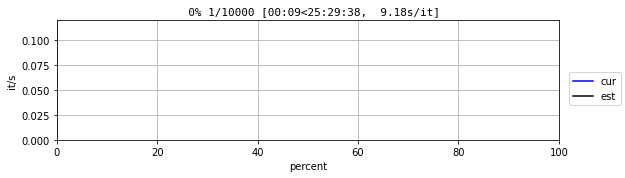

Epoch 1 Dis 1.368559718132019 Gen 0.6724464297294617
Epoch 2 Dis 1.3167047500610352 Gen 0.6862547397613525
Epoch 3 Dis 1.2830445766448975 Gen 0.7081862688064575
Epoch 4 Dis 1.2455956935882568 Gen 0.7048064470291138
Epoch 5 Dis 1.2529186010360718 Gen 0.7450158596038818
Epoch 6 Dis 1.1936588287353516 Gen 0.7567192316055298
Epoch 7 Dis 1.1847460269927979 Gen 0.7792407274246216
Epoch 8 Dis 1.1948050260543823 Gen 0.8335720896720886
Epoch 9 Dis 1.1741719245910645 Gen 0.8148560523986816
Epoch 10 Dis 1.1580848693847656 Gen 0.8739858865737915
Epoch 11 Dis 1.1627883911132812 Gen 0.8102995157241821
Epoch 12 Dis 1.1470705270767212 Gen 1.0107877254486084
Epoch 13 Dis 1.147125005722046 Gen 0.789804220199585
Epoch 14 Dis 1.0988082885742188 Gen 0.957984209060669
Epoch 15 Dis 1.1290794610977173 Gen 0.8382445573806763
Epoch 16 Dis 1.106982707977295 Gen 1.0466899871826172
Epoch 17 Dis 1.235700011253357 Gen 0.8151382803916931
Epoch 18 Dis 1.192776083946228 Gen 1.0785670280456543
Epoch 19 Dis 1.17245972156

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from skvideo import io
from tqdm.gui import tqdm


def genSamples(g, n=8, e=1):
    with torch.no_grad():
        s = g(torch.rand((n**2, 256), device='cuda')*2-1,
              test=True).cpu().detach().numpy()
    out = np.zeros((1, 20, 64*n, 64*n))

    for j in range(n):
        for k in range(n):
            out[:, :, 64*j:64*(j+1), 64*k:64*(k+1)] = s[j*n + k, 0, :, :, :]

    out = out.transpose((1, 2, 3, 0))
    out = (np.concatenate([out, out, out], axis=3)+1) / 2 * 255
    io.vwrite(f'drive/MyDrive/movingMNIST_result/gensamples_id{e}.gif', out)


def subsample_real(h, frames=4):
    h = h[:, np.random.randint(min(frames, h.shape[1]))::frames]
    return h


def full_subsample_real(h, frames=4):
    out = []
    for i in range(4):
        if i:
            out.append(subsample_real(out[i-1], frames=frames))
        else:
            out.append(h)

    for i in range(4):
        for j in range(3-i):
            out[i] = F.avg_pool3d(out[i], kernel_size=(1, 2, 2))
    return out


def zero_centered_gp(real_data, pr):
    gradients = torch.autograd.grad(outputs=pr, inputs=real_data,
                                    grad_outputs=torch.ones_like(pr),
                                    create_graph=True, retain_graph=True)

    return sum([torch.sum(torch.square(g)) for g in gradients])


def train():
    epochs = 10000
    batch_size = 32
    lambda_val = 0.5

    # data
    test = MovingMNIST('moving/', train=False)
    loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True,
                                         drop_last=True)

    def dataGen():
        while True:
            for d in loader:
                yield d

    dg = dataGen()
    # gen model
    dis = DisMultiResNet(channels=[32, 32, 64, 128, 256], colors=1).cuda()
    gen = Generator_CLSTM(
        tempc=256,
        zt_dim=4,
        upchannels=[128],
        subchannels=[64, 32, 32],
        n_frames=20,
        colors=1
    ).cuda()
    # original paper doesn't use TTUR but it is generally effective
    disOpt = torch.optim.Adam(dis.parameters(), lr=5e-5, betas=(0, 0.9))
    genOpt = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=(0, 0.9))

    # train
    # note on loss function: within the current github repo they
    # employ softplus linear loss, if the normal cross entropy
    # is desired one may simply change the comments
    for epoch in tqdm(range(epochs)):
        # discriminator
        disOpt.zero_grad()
        real = torch.cat(next(dg), dim=1).cuda().unsqueeze(2)
        real = real.to(dtype=torch.float32) / 255 * 2 - 1
        real = full_subsample_real(real)
        for i in real:
            i.requires_grad = True
        pr = dis(real)
        dis_loss = zero_centered_gp(real, pr) * lambda_val
        with torch.no_grad():
            fake = gen(torch.rand((batch_size, 256), device='cuda')*2-1)
        pf = dis(fake)
        # dis_loss = -torch.mean(torch.log(pr) + torch.log(1-pf))
        dis_loss += torch.mean(F.softplus(-pr)) + torch.mean(F.softplus(pf))
        dis_loss.backward()
        disOpt.step()
        # generator
        genOpt.zero_grad()
        fake = gen(torch.rand((batch_size, 256), device='cuda')*2-1)
        pf = dis(fake)
        # gen_loss = -torch.mean(torch.log(pf))
        gen_loss = torch.mean(F.softplus(-pf))
        gen_loss.backward()
        genOpt.step()
        # log results
        print('Epoch', epoch, 'Dis', dis_loss.item(), 'Gen', gen_loss.item())
        if epoch % 100 == 0:
            genSamples(gen, e=epoch)


if __name__ == '__main__':
    train()


In [ ]:
# !git clone https://github.com/Zasder3/Tganv2-PyTorch-Train-Sparsely--Generate-Densely.git